# Data Analysis

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

# I get this because of a copy warning using dataframes. More info is found here:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# Ignoring all warnings is a horrible practice if you are running the code for the first time.
# However, upon further research I deemed the warning irrelevant, so I suppress it to make the output clean.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data Cleaning

In [2]:
def clean_data(df):
    
    #Time when Riot started adding timestamps
    beginning = 1623987436
    
    #Naming the columns
    df.columns = ["puuid", "match_id", "start_time", "duration"]

    #Drop duplicate values
    df.drop_duplicates(inplace=True)

    #Changing from milliseconds to seconds
    df["start_time_seconds"] = df["start_time"]/1000

    #Creating column of datetimes for the start time of games
    df["start_time_date"] = df["start_time_seconds"].apply(lambda x : datetime.datetime.fromtimestamp(int(x)))

    #Start time is measured in epoch time ms, so we convert to seconds
    df["start_time_seconds"] = df["start_time"]/1000
    
    #There are some games where the timestamps are messed up and start at 0, corresponding to 1970 (look up unix time)
    #So we remove these
    df = df[df["start_time_seconds"] > beginning]
    
    #duration is sometimes measured in seconds and sometimes in ms, so we conver to seconds via some condition
    df["duration_seconds"] = df["duration"].apply(lambda x : x/1000  if x/60 > 120 else x)

    #createa column for end_time since this is not tracked in all of the json files
    df["end_time_seconds"] = df["start_time_seconds"] + df["duration_seconds"]

    #Sort the values by start_time
    df.sort_values(by = "start_time_seconds", ascending=True, inplace=True, ignore_index=True)

    #Creating a new column which measures the time difference between the end of a game and the beginning of the next one
    del_t = []
    del_t.append(0)

    for i in range(1,len(df["start_time_seconds"])):

        del_t.append(df["start_time_seconds"][i] - df["end_time_seconds"][i-1])

    #In seconds
    df["del_t"] = del_t

    #Want the time between games in hours
    df["del_t_hours"] = df["del_t"]/(60*60)
    
    return(df)

# Frequency of Games Played for 10 LoL Players

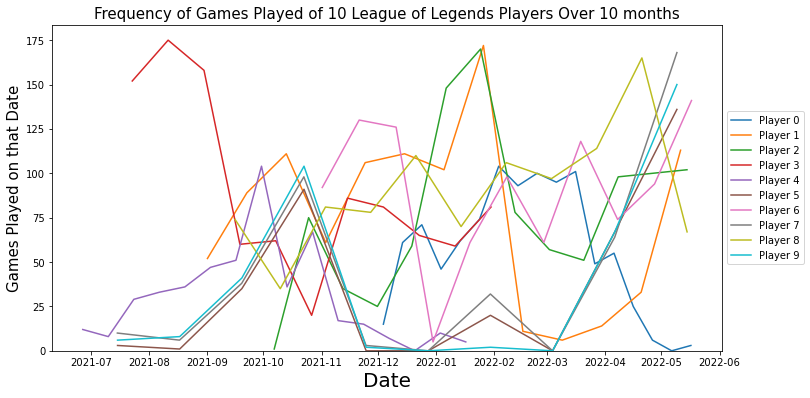

In [3]:
fig, ax = plt.subplots(figsize = (12,6))

c_list = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"]

for i, filepath in enumerate(os.listdir("Player_Time_Data_2/")):
    
    df = pd.read_csv("Player_Time_Data_2/{}".format(filepath),
                      dtype='str,str,float,float,bool', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
    df = clean_data(df)
    
    sns.histplot(data = df["start_time_date"], 
                 element = 'poly', 
                 fill= False, 
                 ax = ax, 
                 ls = "solid", 
                 color = c_list[i],
                 label = "Player {}".format(i),
                )
    
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Games Played on that Date", fontsize = 15)
plt.title("Frequency of Games Played of 10 League of Legends Players Over 10 months", fontsize = 15)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    

This graph represents how many times a summoner played a game at a certain date. There doesn't appear to be any evident pattern, but if you notice players 0,1,2 their play frequencies seem to align pretty well. I looked them up and turns out they queue up together fairly often.

Graphs like this lose any sort of valuable information the more summoners there are in the plot. So let's check out some other ways to visually explore the data.

# Time Between Games Played for one LoL Player

In [4]:
df = pd.read_csv("Player_Time_Data_2/player_0_times.txt",
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
df = clean_data(df)

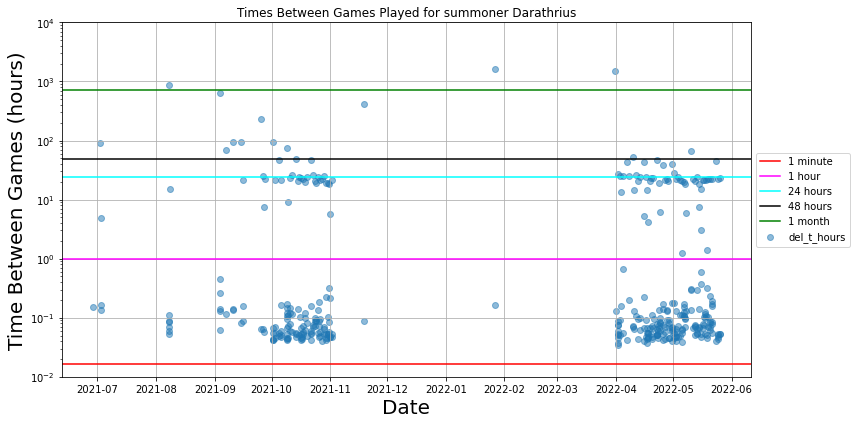

In [7]:
fig, ax = plt.subplots(figsize = (12,6))

ax.scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)

ax.axhline(y = 1/60,   c = "red",     label = "1 minute")
ax.axhline(y = 1,      c = "magenta", label = "1 hour")
ax.axhline(y = 24,     c = "cyan",    label = "24 hours")
ax.axhline(y = 48,     c = "black",   label = "48 hours")
ax.axhline(y = 24*30,  c = "green",   label = "1 month")


ax.set_yscale("log")
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Time Between Games (hours)", fontsize = 20)


from riotwatcher import LolWatcher


watcher = LolWatcher(api_key="RGAPI-baa32468-2b11-4c4c-a848-2d877f73610d")
summoner_name = watcher.summoner.by_puuid('na1',df["puuid"][0])["name"]
plt.title("Times Between Games Played for summoner {}".format(summoner_name))


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
#plt.xlim(datetime.datetime.fromtimestamp(1632385853), datetime.datetime.fromtimestamp(1632817853))
plt.ylim(.01,10000)
plt.tight_layout()

In the plot above, on the x-axis is the start time of a game in terms of the date. On the y-axis is the time between the start of that game and the end of the previous game, $\Delta t$. This is the key metric we wish to analyze as it determines if a player almost churned: if $\Delta t$ is very large, it means it's the first time a summoner played a game in a long period of time.

# Time Between Games Played for 10 LoL Players

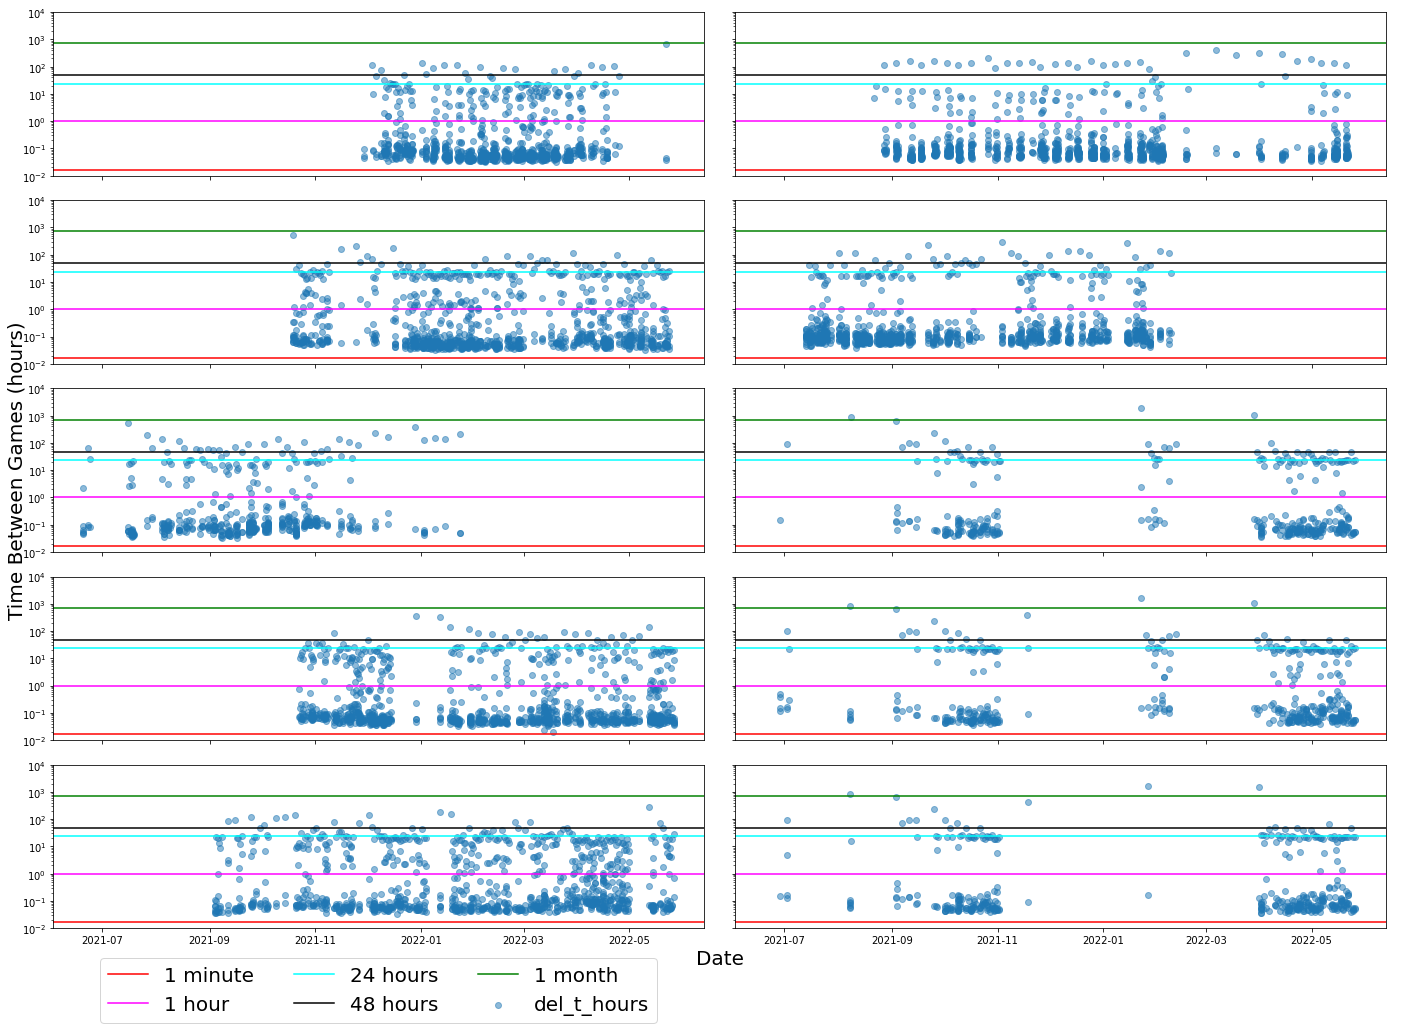

In [6]:
fig, axes = plt.subplots(nrows = 5, 
                       ncols=2, 
                       figsize = (20,15), 
                       sharex=True, 
                       sharey=True)


axis_list = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1)]

for i, filepath in enumerate(os.listdir("Player_Time_Data_2/")):
    
    df = pd.read_csv("Player_Time_Data_2/{}".format(filepath),
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
    df = clean_data(df)
    
    axes[axis_list[i]].scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)
    
    
    axes[axis_list[i]].axhline(y = 1/60,c = "red", label = "1 minute")
    axes[axis_list[i]].axhline(y = 1,   c = "magenta", label = "1 hour")
    axes[axis_list[i]].axhline(y = 24,  c = "cyan", label = "24 hours")
    axes[axis_list[i]].axhline(y = 48,  c = "black", label = "48 hours")
    axes[axis_list[i]].axhline(y = 24*30,  c = "green", label = "1 month")
    
    axes[axis_list[i]].set_yscale("log")
    
    #plt.xlabel("Date", fontsize = 20)
    #plt.ylabel("Hours Between Games", fontsize = 20)
    #plt.grid()
    plt.ylim(.01,10000)

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Time Between Games (hours)", fontsize = 20)
  
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
axes.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, prop={'size': 20})    


plt.tight_layout()

There are a few summoners who almost churned, represented by large gaps in points within a plot. In fact the same 3 players were the ones tha almost churned as they had 2 instances where more than a month passed by since they played their last game.

One player actually churned completely, shown in plot (1,1).

# Many Summoners' Data Analysis

Ok, so we explored a bit an individual summoner's game trends, and a group of 10 summoners' game trends. How do we explore data of many many summoners?

There isn't any good way to visualize $\Delta t$ for many players except by aggregating by the date. So let's do that and explore.

The timestamps go from $t = INSERT BEGINNING TIME HERE$ to $t = INSERT NOW TIME HERE$. However, the actualy timestamps don't have any sort of consistency, in that almost every single data point started at a different point in time than any other, since this is measured in ms. So we have to do some kind of grouping.

We can split up the timeframe into different time slices, and group up games according to the time they began. We will experiment with different time slice lengths.


We will define the time slice as $\delta t = \frac{t_{now} - t_{beginning}}{N}$.

If a game's start time falls in $i \delta t \leq  b < (i+1) \delta t$ then it belongs to slice $i$. 

After this, each game will be assigned to a certain time slice and we can aggregate the values of $\Delta t$ and find trends as a function of time.

In [22]:
#Start time and end time
beginning = 1623984449
now = 1653528536 #May want to add 4 days since I have data for this as well


#Getting the datetime object of beginning time and now time
beginning_date = datetime.datetime.fromtimestamp(beginning)
now_date = datetime.datetime.fromtimestamp(now)


#Number of slices
N = (now_date - beginning_date).days


#Time slice length
del_t = (now - beginning) / N

#List of time slices
slices = np.linspace(beginning, now, N)

In [24]:
#Creating function that will assign index of time slice
def time_slice_assign(start_time):
    
    for i in range(len(slices)):

        if (slices[i]  <= start_time) and (start_time < slices[i+1]):

            return (i)

In [25]:
def clean_data(df):
    
    add_4_days = 60*60*24*4
    
    #Time when Riot started adding timestamps
    beginning = 1623987436
    
    #Naming the columns
    df.columns = ["puuid", "match_id", "start_time", "duration", "win"]

    #Drop duplicate values
    df.drop_duplicates(inplace=True)

    #Changing from milliseconds to seconds
    df["start_time_seconds"] = df["start_time"]/1000

    #Creating column of datetimes for the start time of games
    df["start_time_date"] = df["start_time_seconds"].apply(lambda x : datetime.datetime.fromtimestamp(int(x)))

    
    #There are some games where the timestamps are messed up and start at 0, corresponding to 1970 (look up unix time)
    #So we remove these
    df = df[df["start_time_seconds"] > beginning]
    
    
    df = df[df["start_time_seconds"] < now]
    
    #duration is sometimes measured in seconds and sometimes in ms, so we conver to seconds via some condition
    df["duration_seconds"] = df["duration"].apply(lambda x : x/1000  if x/60 > 120 else x)

    #createa column for end_time since this is not tracked in all of the json files
    df["end_time_seconds"] = df["start_time_seconds"] + df["duration_seconds"]

    #Sort the values by start_time
    df.sort_values(by = "start_time_seconds", ascending=True, inplace=True, ignore_index=True)

    #Creating a new column which measures the time difference between the end of a game and the beginning of the next one
    del_t = []
    del_t.append(0)

    for i in range(1,len(df["start_time_seconds"])):

        del_t.append(df["start_time_seconds"][i] - df["end_time_seconds"][i-1])

    #In seconds
    df["del_t"] = del_t

    #Want the time between games in hours
    df["del_t_hours"] = df["del_t"]/(60*60)
    
    return(df)

# ERROR: SLICES START AT 10 INSTEAD OF 0 WHEN N = 100,000

In [26]:
#Getting all available files, combining them into one dataframe 

for i, file in enumerate(os.listdir("Player_Time_Data_Large_2/")):
    
    if file == ".ipynb_checkpoints": continue
    
    df = pd.read_csv("Player_Time_Data_Large_2/{}".format(file),
                      dtype='str,str,float,float,bool', 
                      delimiter = " ",
                      usecols=(0,1,2,3,4),
                      header = None
                    )

    df = clean_data(df)

    if i == 0:
        df_new = df
    
    else:
        df_new = pd.concat([df_new, df])
    

In [27]:
#This code takes over 25 minutes to do because my time slice code is not well optimized for N = 100,000
#So both of these 2 snippets of code do the same thing, but the second one lets you keep track of which
# row you're on.

df_new["time_slice"] = df_new["start_time_seconds"].apply(time_slice_assign)

#index_list = []
#
#for i, time in enumerate(df_new["start_time_seconds"]):
#    
#    index_list.append(time_slice_assign(time))
#    print("added {}th time of {}".format(i, len(df_new["start_time_seconds"])))

#df_new["time_slice"] = index_list

In [32]:
#Grouping df by time slices 
grouped_slices = df_new.groupby("time_slice").mean()

In [44]:
#Taking the grouped df and for each row, assigning the i'th slice of time its corresponding time value
#The observant reader will note that df_new (the df that contained all rows of player data) also had a col
# called start_time_date and it may appear that we are overwriting this columns. This is not the case 
# since start_time_date could not be averaged (as it is a datetime object), it was ommitted when creating 
# the grouped_slices df. So we may create a column called start_time_date.

time_date_ints = (slices[grouped_slices.index])

time_dates = []

for time in time_date_ints:
    time_dates.append(datetime.datetime.fromtimestamp(time))

grouped_slices.index = time_dates

In [45]:
grouped_slices.head()

,start_time,duration,win,start_time_seconds,duration_seconds,end_time_seconds,del_t,del_t_hours,start_time_date
2021-06-17 19:47:29.000000,1.624033e+12,1.392856e+06,0.543147,1.624033e+09,1392.855584,1.624034e+09,3778.992574,1.049720,2021-06-17 19:47:29.000000
2021-06-18 19:55:43.373529,1.624112e+12,1.397581e+06,0.550265,1.624112e+09,1397.580693,1.624113e+09,10271.942228,2.853317,2021-06-18 19:55:43.373529
2021-06-19 20:03:57.747059,1.624206e+12,1.379547e+06,0.488764,1.624206e+09,1379.546551,1.624207e+09,13791.847708,3.831069,2021-06-19 20:03:57.747059
2021-06-20 20:12:12.120588,1.624289e+12,1.369514e+06,0.493671,1.624289e+09,1369.513652,1.624291e+09,16977.430677,4.715953,2021-06-20 20:12:12.120588
2021-06-21 20:20:26.494118,1.624380e+12,1.431240e+06,0.531250,1.624380e+09,1431.239987,1.624381e+09,20343.722937,5.651034,2021-06-21 20:20:26.494118


<AxesSubplot:xlabel='start_time_date', ylabel='del_t_hours'>

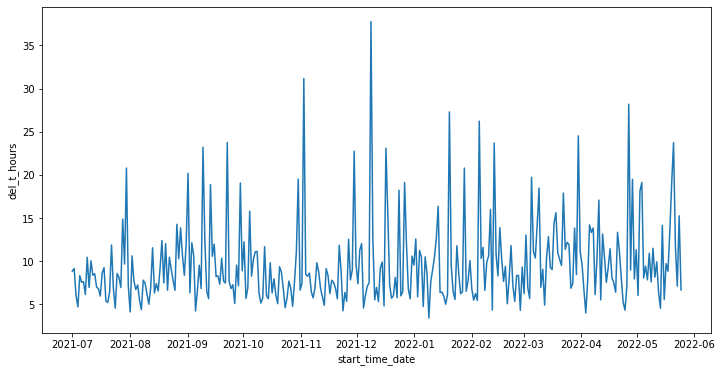

In [83]:
plt.figure(figsize = (12,6))
sns.lineplot(x = "start_time_date",
            y = "del_t_hours",
            data = grouped_slices[grouped_slices["start_time_seconds"] >= 1625128557]) #Points after july 1, 2021

In [47]:
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [84]:
grouped_slices_07_01 = grouped_slices[grouped_slices["start_time_seconds"] >= 1625128557]

In [85]:
time_series = pd.Series(data = grouped_slices_07_01["del_t_hours"],
         #index = grouped_slices["start_time_date"]
         )

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

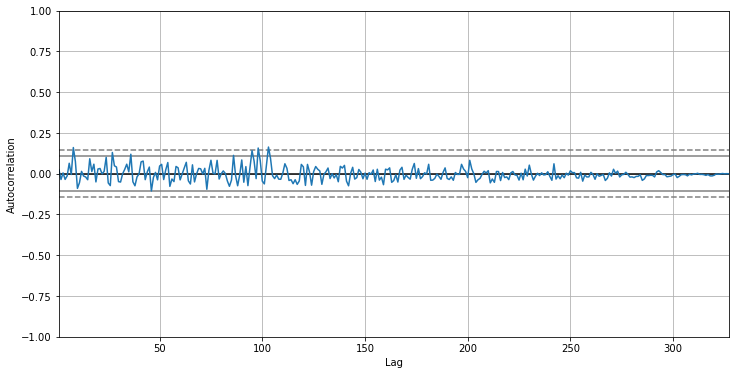

In [88]:
plt.figure(figsize = (12,6))
autocorrelation_plot(time_series)

Looking at the autocorrelation function this data only appears to be correlated at a few lag points. Meaning there seems to be no trend or seasonality. Let's confirm this with a Dickey-Fuller test for stationarity.

In [87]:
adft = adfuller(time_series,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -1.755876e+01              Test Statistics
1  4.106820e-30                      p-value
2  0.000000e+00             No. of lags used
3  3.260000e+02  Number of observations used
4 -3.450569e+00          critical value (1%)
5 -2.870447e+00          critical value (5%)
6 -2.571515e+00         critical value (10%)


Since we have a p-value less than .05, we reject the null hypothesis, and accept the alternative: this time series is stationary (no significant trend or seasonality).

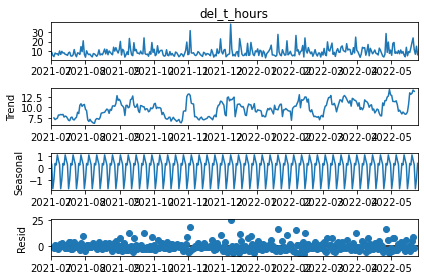

In [105]:
decompose_7 = seasonal_decompose(time_series, 
                               #model='additive', 
                               period=7
                              )
decompose_7.plot()


plt.show()

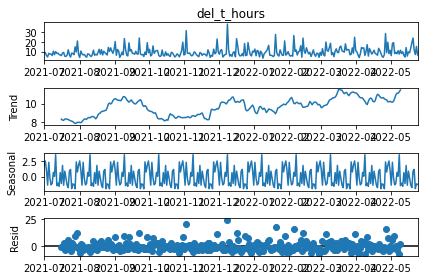

In [107]:
decompose_30 = seasonal_decompose(time_series, 
                               #model='additive', 
                               period=30
                              )
decompose_30.plot()

plt.show()

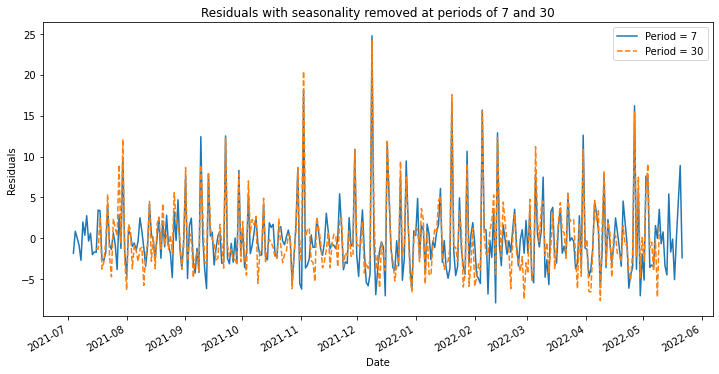

In [116]:
fig, ax = plt.subplots(figsize = (12,6))
decompose_7.resid.plot(ax = ax, label = "Period = 7")
decompose_30.resid.plot(ax = ax, label = "Period = 30", ls = '--')
plt.title("Residuals with seasonality removed at periods of 7 and 30")
plt.ylabel("Residuals")
plt.xlabel("Date")
plt.legend()

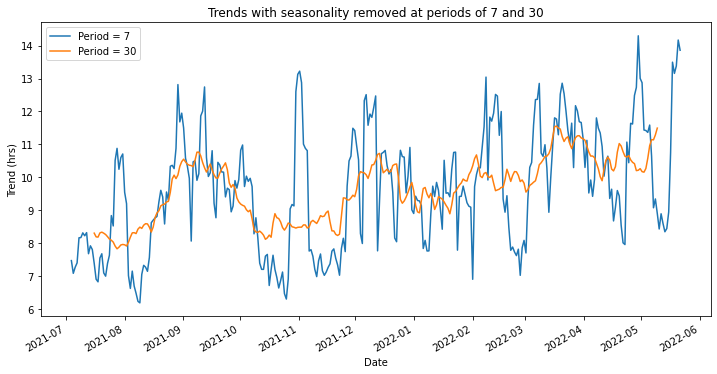

In [113]:
fig, ax = plt.subplots(figsize = (12,6))
decompose_7.trend.plot(ax = ax, label = "Period = 7")
decompose_30.trend.plot(ax = ax, label = "Period = 30")
plt.title("Trends with seasonality removed at periods of 7 and 30")
plt.ylabel("Trend (hrs)")
plt.xlabel("Date")
plt.legend()